# Define Functions to Get PM(C)IDs and Openness

In [90]:
import requests
from bs4 import BeautifulSoup
from re import *

import numpy as np
import pandas as pd
from collections import defaultdict
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
# Get PMCID from PMID
def get_pmcid_year(pmid):
    base_url = f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/"
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    date = soup.find_all('span', {'class' : 'cit'})[0].text.strip().split()[0]
    try:
        pmcid = soup.find_all('a', {'class' : 'id-link', 'data-ga-action' : 'PMCID'})[0].text.strip()
    except:
        pmcid = None
    return (pmcid , date)

print("Closed example: ", get_pmcid_year("35770940"))
print("Open example: ", get_pmcid_year("35165460"))

Closed example:  (None, '2023')
Open example:  ('PMC7612594', '2022')


In [50]:
# Get list of PMIDs from author name
def get_pmids_open(author):
    
    # Parse author name, build first+last
    author = author.split()
    if len(author) > 1:
        aname = author[0]
        for name in author[1:]:
            aname += "+" + name
    else:
        aname = author[0]
        
    #find total number of pages
    base_url= f'https://pubmed.ncbi.nlm.nih.gov/?term={aname}&page='
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    pages = soup.find_all('label', {'class' : 'of-total-pages'})
    p = pages[0].text.strip()
    p = p.split()
    pagenum=int(p[1])
    
    # scrape pubmed
    pmids = []
    entries = []
    for i in range(1,pagenum+1): #change # into max num of pages
        URL = f'https://pubmed.ncbi.nlm.nih.gov/?term={aname}&page={i}'
        response = requests.get(URL)
        soup = BeautifulSoup(response.content, 'html.parser')
        pmids += soup.find_all('span', {'class' : 'docsum-pmid'})
        entries += soup.find_all("div", class_='docsum-content')
    
    # build dictionary of id:pmcid
    ids = {}
    years = {}
    for id,entry in zip(pmids,entries):
        pmcid, year = get_pmcid_year(id.text.strip())
        years[id.text.strip()] = year
        if pmcid:
            ids[id.text.strip()] = pmcid
        elif search(r"Free",entry.text.strip()): # use regex to search for "Free" in docsum-content
            ids[id.text.strip()] = "open"
        else:
            ids[id.text.strip()] = "closed"
        
    return ids, years

print("Jennifer: ", get_pmids_open("jennifer jahncke"))
print("Emily L: ", get_pmids_open("emily lecy"))
print("Arpy: ", get_pmids_open("arpiar saunders"))

Jennifer:  ({'35770940': 'closed', '35944998': 'PMC9480892', '32321746': 'PMC7204083', '37540708': 'open'}, {'35770940': '2023', '35944998': '2022', '32321746': '2020', '37540708': '2023'})
Emily L:  ({'36792646': 'PMC9932154', '36582611': 'PMC9792983', '33906174': 'PMC8504120'}, {'36792646': '2023', '36582611': '2022', '33906174': '2021'})
Arpy:  ({'30471926': 'PMC6655561', '30096299': 'PMC6447408', '34197733': 'PMC8376805', '32999462': 'PMC7957574', '29632380': 'PMC5896795', '26220313': 'PMC4584188', '26131660': 'PMC4545963', '22660328': 'PMC3367801', '36384944': 'PMC9668842', '33230336': 'closed', '26551563': 'PMC4716836', '32613945': 'PMC7360370', '25723967': 'PMC4371381', '26905595': 'PMC4764347', '25739505': 'PMC4425585', '21825165': 'PMC3174680', '28384468': 'PMC5439268', '22866029': 'PMC3406316', '19056989': 'closed', '23403489': 'PMC3566411', '22325203': 'PMC3278709', '26104011': 'closed'}, {'30471926': '2019', '30096299': '2018', '34197733': '2021', '32999462': '2020', '29632

In [150]:
def get_openness(author, api):
    ids, years = get_pmids_open(author)
    
    apikey = open(api, 'r').read()
    
  # Load keywords and create open-science categories
    keyword_df = pd.read_csv('keywords.csv')
    categoryIDs = np.unique(np.array(keyword_df['category']))
    category_descriptions = keyword_df['category_description']
    category_descriptions = category_descriptions.unique().tolist()
    full_text = 'full_text'
    category_descriptions.append(full_text)
    
    #create df with all the unique categories:
    #data = [[None] * len(ids) for _ in range(len(category_descriptions))]
    data = (len(ids), len(category_descriptions))

    #data = (len(ids), len(category_descriptions))
    o_idx_df = pd.DataFrame(np.zeros(data), columns = category_descriptions)
    #deleting the 'code relevant column from the final df
    pmcids = []
    for i, item in enumerate(ids): 
        o_idx_df.loc[[i],['pmid']] = item
        o_idx_df.loc[[i],['year']] = np.array(years[item])
        if ids[item] == 'closed':
            pmcids.append(None)
            #if PMCID is unavailable make items in df None type
            o_idx_df.iloc[[i],0:2] = None
            continue
        if ids[item] == 'open':
            pmcids.append(None)
            o_idx_df.loc[[i],['full_text']] = 1
            o_idx_df.iloc[[i],0:2] = None

        else:
            pmcids.append(ids[item])
            o_idx_df.loc[[i],['full_text']] = 1
    db = 'pmc'
    base = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?'
    for j, pmcid in enumerate(pmcids):
        if pmcid == None:
            continue
        s = '{:s}db={:s}&id={:s}'.format(base, db, pmcid, apikey)
        out = requests.get(s)
        bs = BeautifulSoup(out.content, features="xml")
        # Check if full text is available; if not - move to the next paper
        for cat in categoryIDs:
            found_keyword = False
            # Loop through specific keywords related to each open-science category
            for k, keyword in enumerate(keyword_df['keyword'][keyword_df['category'] == cat]):
                for s in finditer(keyword, out.text, IGNORECASE):
                    #if we are on cat "code relevant" (cat 3) we are testing to see if code is relevant for this paper
                    o_idx_df.iloc[[j],[cat-1]] = keyword_df.loc[k]["weight"]
                    found_keyword = True

                # If one keyword is found, stop with searching for this category
                if found_keyword is True:
                    break
            #if code category is 0, check to see if code is relevant
            if cat == 2 and found_keyword== True:
                break 
            if cat == 3 and found_keyword == False:
                o_idx_df.iloc[[j],[cat-2]] = None
                break    
                
    del o_idx_df['code_relevant']
        
    o_idx_df.loc[:,'Score'] = o_idx_df.mean(numeric_only=True, axis=1)
   
    OIndex=o_idx_df["Score"].mean()
    print(OIndex)

    return o_idx_df

def oindex(df):
    OIndex = np.array(df["o-score"].mean())
    
    

o_df = get_openness("Subimal Datta", "../apikey.txt")
o_df

0.4242424242424242


,data,code,full_text,pmid,year,Score
0,0.0,NaN,1.0,37004410,2023,0.500000
1,0.0,NaN,1.0,20359944,2010,0.500000
2,0.0,NaN,1.0,30856085,2020,0.500000
3,0.0,NaN,1.0,25151622,2014,0.500000
4,0.0,NaN,1.0,17251375,2007,0.500000
5,0.0,NaN,1.0,29084240,2017,0.500000
6,0.0,NaN,1.0,17445891,2007;31(5):775-824.,0.500000
7,0.0,NaN,1.0,28810411,2019,0.500000
8,0.0,0.0,1.0,28729826,2017,0.333333
9,0.0,NaN,1.0,29379611,2017,0.500000


[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'O-Score'),
 Text(0.5, 1.0, 'Yearly O-Score')]

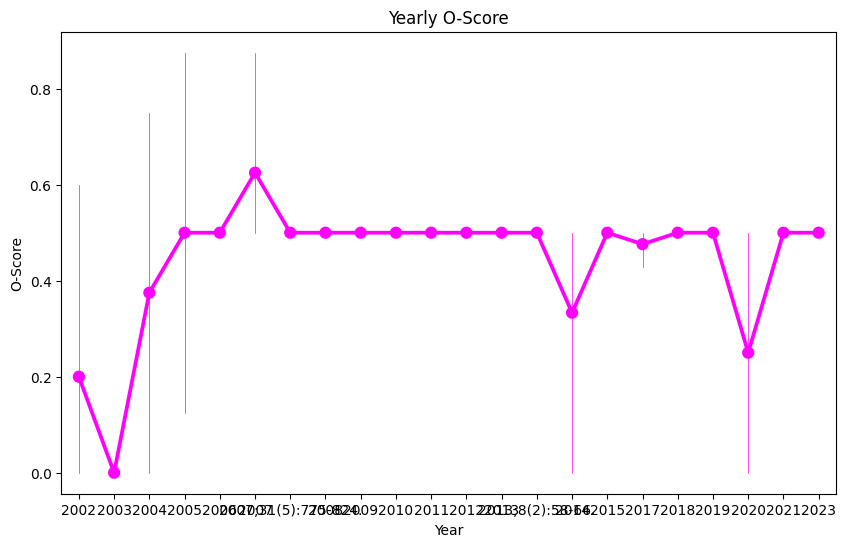

In [151]:
# #plt.plot(np.array(o_df.sort_values(by ='year')['year']), np.array(o_df.sort_values(by ='year')['Score']))
# agg_df = o_df.groupby('year')['Score'].mean().reset_index()
# agg_df
# # years = np.array(agg_df['year'])
# # score = np.array(agg_df['Score'])
# # sns.lineplot(x=years, y=score)
plt.figure(figsize=(10, 6))
ax = sns.pointplot(data = o_df.sort_values(by ='year'), x= 'year', y= 'Score', color = 'magenta', errwidth=0.5)
ax.set(xlabel='Year',
       ylabel='O-Score',
       title='Yearly O-Score')
